# CrimeLens — Data Setup Notebook

This notebook creates **starter datasets** for Deliverable 1 and verifies that the environment runs cleanly.

**Outputs created:**
- `data/sample_transcripts.csv` — small audio→text segments (placeholder)  
- `data/chicago_incidents_sample.csv` — real subset from Chicago Open Data (if network available; otherwise a local fallback)  
- `data/crimelens_graph.json` — tiny knowledge-graph JSON from transcripts  
- A visible matplotlib plot + printed summary stats

## 0) Setup  
Install minimal runtime dependencies if needed.

In [1]:
import os, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
print("Data directory:", DATA_DIR.resolve())

Data directory: /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/data


## 1) (Optional) Transcribe audio via Whisper
If you have podcast audio (e.g., *Serial* S1 MP3s), you can transcribe them with Whisper.

```bash
pip install openai-whisper
whisper episode1.mp3 --model base.en --output_format json --output_dir data

In [2]:
# #### Code Cell 2
# ```python
# # Example converter for Whisper JSON output (uncomment and point to your file)
# # import json, pandas as pd
# # with open("data/episode1.json") as f:
# #     res = json.load(f)
# # segs = res.get("segments", [])
# # df = pd.DataFrame([{
# #     "episode": "1",
# #     "speaker": "unknown",
# #     "text": s.get("text","").strip(),
# #     "start": s.get("start", 0.0),
# #     "end": s.get("end", 0.0)
# # } for s in segs])
# # df.to_csv("data/serial_ep1_transcript.csv", index=False)
# print("Using a small placeholder CSV next...")

## 2) Create a placeholder transcripts CSV  
Ensures the repo runs even without audio files. Replace later with real Whisper outputs.

In [3]:
sample_transcripts = [
    {"episode":1,"speaker":"Narrator","text":"A loud noise was heard near the alley.","start":0,"end":8},
    {"episode":1,"speaker":"Witness","text":"I saw a man running away.","start":8,"end":15},
    {"episode":1,"speaker":"Investigator","text":"Collected fingerprints near the scene.","start":15,"end":25},
    {"episode":2,"speaker":"Narrator","text":"The suspect was last seen on 5th Avenue.","start":0,"end":7},
    {"episode":2,"speaker":"Witness","text":"He dropped a bag near the cafe.","start":7,"end":12},
]
df_trans = pd.DataFrame(sample_transcripts)
csv_path = DATA_DIR / "sample_transcripts.csv"
df_trans.to_csv(csv_path, index=False)
print("Wrote:", csv_path, f"({len(df_trans)} rows)")
df_trans.head()

Wrote: data/sample_transcripts.csv (5 rows)


,episode,speaker,text,start,end
0,1,Narrator,A loud noise was heard near the alley.,0,8
1,1,Witness,I saw a man running away.,8,15
2,1,Investigator,Collected fingerprints near the scene.,15,25
3,2,Narrator,The suspect was last seen on 5th Avenue.,0,7
4,2,Witness,He dropped a bag near the cafe.,7,12


## 3) Download a real subset of Chicago Police incidents (or fallback)
Fetch ≈500 rows from the Chicago Open Data endpoint. If network unavailable, write a tiny local fallback.

In [4]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv?$limit=500"
out_csv = DATA_DIR / "chicago_incidents_sample.csv"

try:
    df_chi = pd.read_csv(url)
    keep = [c for c in [
        "case_number","primary_type","description","location_description","arrest","year"
    ] if c in df_chi.columns]
    if keep: df_chi = df_chi[keep]
    df_chi.to_csv(out_csv, index=False)
    print(f"Fetched {len(df_chi)} rows from Chicago Open Data →", out_csv)
except Exception as e:
    print("Fetch failed, creating a small fallback CSV:", e)
    fallback = pd.DataFrame([
        {"case_number":"TEST1","primary_type":"BURGLARY","description":"FORCIBLE ENTRY","location_description":"RESIDENCE","arrest":True,"year":2023},
        {"case_number":"TEST2","primary_type":"ROBBERY","description":"ARMED: HANDGUN","location_description":"STREET","arrest":False,"year":2023},
        {"case_number":"TEST3","primary_type":"BATTERY","description":"SIMPLE","location_description":"BAR","arrest":False,"year":2024},
    ])
    fallback.to_csv(out_csv, index=False)
    print("Wrote fallback:", out_csv, f"({len(fallback)} rows)")

display(pd.read_csv(out_csv).head())

Fetched 500 rows from Chicago Open Data → data/chicago_incidents_sample.csv


,case_number,primary_type,description,location_description,arrest,year
0,JJ453453,CRIMINAL DAMAGE,TO VEHICLE,VACANT LOT / LAND,False,2025
1,JJ447890,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,2025
2,JJ447455,BATTERY,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS ...,RESIDENCE,False,2025
3,JJ447485,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,2025
4,JJ450082,THEFT,$500 AND UNDER,RESIDENCE,False,2025


## 4) Build a tiny knowledge-graph JSON from transcripts
Adds a few nodes/edges that mimic relations extracted from text.

In [5]:
graph = {
    "nodes": [
        {"id": "suspect_A", "type": "person"},
        {"id": "object_X", "type": "evidence"},
        {"id": "room_2", "type": "location"}
    ],
    "edges": [
        {"source": "suspect_A", "target": "object_X", "relation": "touched"},
        {"source": "object_X", "target": "room_2", "relation": "found_in"}
    ]
}
with open(DATA_DIR/"crimelens_graph.json","w") as f:
    json.dump(graph, f, indent=2)
print("Wrote:", (DATA_DIR/"crimelens_graph.json").resolve())
print("Nodes:", len(graph["nodes"]), "| Edges:", len(graph["edges"]))

Wrote: /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/data/crimelens_graph.json
Nodes: 3 | Edges: 2


## 5) Quick EDA + Visible Plot 

## 5b) Chicago Crime Data – Exploratory Plot

This step verifies that the Chicago dataset loads correctly and visualizes the most frequent crime types from the subset.

Rows: 500
Columns: ['case_number', 'primary_type', 'description', 'location_description', 'arrest', 'year']

Top 5 Crime Types:
primary_type
THEFT                  104
BATTERY                 98
ASSAULT                 51
CRIMINAL DAMAGE         48
MOTOR VEHICLE THEFT     45
Name: count, dtype: int64


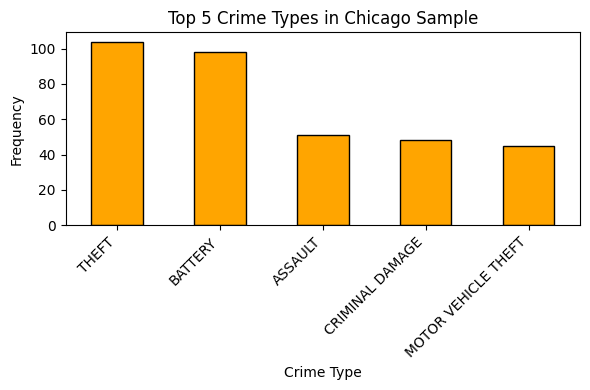

In [6]:
# Load Chicago crime dataset
chi_path = DATA_DIR / "chicago_incidents_sample.csv"
df_chi = pd.read_csv(chi_path)
print("Rows:", len(df_chi))
print("Columns:", list(df_chi.columns))

# Basic EDA
if "primary_type" in df_chi.columns:
    crime_counts = df_chi["primary_type"].value_counts().head(5)
    print("\nTop 5 Crime Types:")
    print(crime_counts)

    # Plot
    plt.figure(figsize=(6,4))
    crime_counts.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("Top 5 Crime Types in Chicago Sample")
    plt.xlabel("Crime Type")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'primary_type' not found. Check dataset schema below:")
    display(df_chi.head())

Transcript rows: 5
Unique episodes: 2
Total duration (s): 37


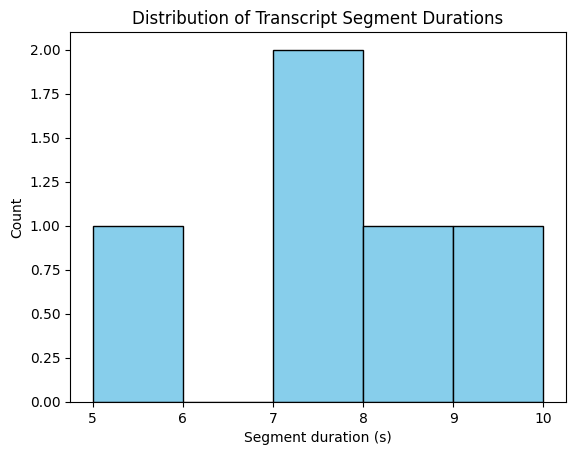

In [7]:
df = pd.read_csv(DATA_DIR/"sample_transcripts.csv")
print("Transcript rows:", len(df))
print("Unique episodes:", df["episode"].nunique())
durations = df["end"] - df["start"]
print("Total duration (s):", durations.sum())

plt.figure()
plt.hist(durations, bins=5, color='skyblue', edgecolor='black')
plt.xlabel("Segment duration (s)")
plt.ylabel("Count")
plt.title("Distribution of Transcript Segment Durations")
plt.show()

## 6) Verification Summary

In [8]:
files = [
    DATA_DIR/"sample_transcripts.csv",
    DATA_DIR/"chicago_incidents_sample.csv",
    DATA_DIR/"crimelens_graph.json"
]
for p in files:
    print("Exists:", p, "| Size:", p.stat().st_size, "bytes")

Exists: data/sample_transcripts.csv | Size: 289 bytes
Exists: data/chicago_incidents_sample.csv | Size: 31618 bytes
Exists: data/crimelens_graph.json | Size: 413 bytes


# 🎙️ Whisper Transcription Setup — CrimeLens

This notebook demonstrates how the Whisper model converts a short public-domain true-crime audio clip into text.  
Audio Source: *True Stories of Crime from the District Attorney’s Office* by Arthur Train (LibriVox Public Domain)

In [9]:
!pip install openai-whisper torch tqdm

import whisper
import os
from pathlib import Path

In [10]:
# Path to the audio sample
audio_path = Path("data/truestoriesofcrime_01_train_64kb.mp3")

# Check file
if audio_path.exists():
    print(f"Found audio file: {audio_path}")
else:
    raise FileNotFoundError("Audio file not found. Please place your MP3 in the data/ folder.")

Found audio file: data/truestoriesofcrime_01_train_64kb.mp3


In [16]:
# Load Whisper model
model = whisper.load_model("base")

# Transcribe
result = model.transcribe(str(audio_path))
print("---- TRANSCRIPT ----\n")
print(result["text"])

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


---- TRANSCRIPT ----

 Chapter 1 of True Stories of Crime from the District Attorney's Office This is a Libravox Recording. All Libravox recordings are in the public domain. For more information or to volunteer, please visit Libravox.org Recording by Colleen McMahon. True Stories of Crime from the District Attorney's Office by Arthur Cheney Train. Preface The narratives composing this book are literally true stories of crime In a majority of the cases, the author conducted the prosecution himself, and therefore may claim to have a personal knowledge of that whereof he speaks. While no confidence has been abused, no essential facts have been omitted, distorted, or colored, and the accounts themselves being all matters of public record may be easily verified. The scenes recorded here are not literature but history, and the characters who figure in them are not puppets of the imagination, but men and women who lived and schemed, laughed, sinned, and suffered, and paid the price when the t

In [17]:
import pandas as pd
from pathlib import Path

# `result` is the Whisper output you already have
segments = result.get("segments", [])
assert segments, "No segments returned by Whisper—check the audio path or model."

df = pd.DataFrame([
    {
        "episode": "true_stories_ch1",
        "speaker": "narrator",                 # diarization optional; set default
        "text": s.get("text", "").strip(),
        "start": float(s.get("start", 0.0)),
        "end": float(s.get("end", 0.0)),
    }
    for s in segments
])

out_csv = Path("data/true_stories_transcript.csv")
df.to_csv(out_csv, index=False)
print(f"Saved {len(df)} segments → {out_csv.resolve()}")
df.head()

Saved 189 segments → /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/data/true_stories_transcript.csv


,episode,speaker,text,start,end
0,true_stories_ch1,narrator,Chapter 1 of True Stories of Crime from the Di...,0.0,5.0
1,true_stories_ch1,narrator,This is a Libravox Recording. All Libravox rec...,5.0,10.0
2,true_stories_ch1,narrator,"For more information or to volunteer, please v...",10.0,15.0
3,true_stories_ch1,narrator,Recording by Colleen McMahon.,15.0,17.0
4,true_stories_ch1,narrator,True Stories of Crime from the District Attorn...,17.0,22.0


Rows: 189
Total audio duration (s): 2104.0
Avg segment length (s): 11.01
Words: 6302


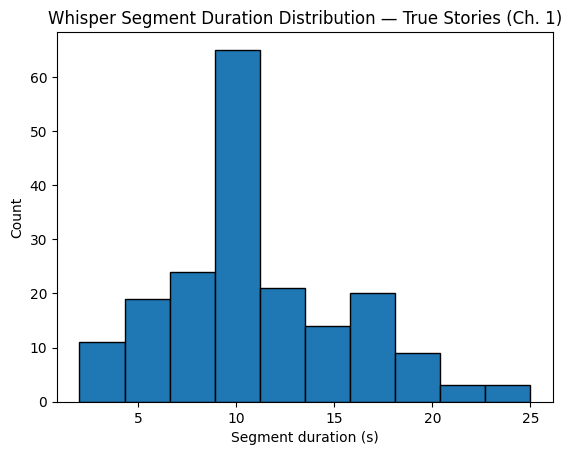

In [18]:
import matplotlib.pyplot as plt

dur = df["end"] - df["start"]
print("Rows:", len(df))
print("Total audio duration (s):", round(float(df["end"].max()), 2))
print("Avg segment length (s):", round(dur.mean(), 2))
print("Words:", df["text"].str.split().str.len().sum())

plt.figure()
plt.hist(dur, bins=10, edgecolor="black")
plt.xlabel("Segment duration (s)")
plt.ylabel("Count")
plt.title("Whisper Segment Duration Distribution — True Stories (Ch. 1)")
plt.show()